In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os

from EWPortfolio0 import EquallyWeightedPortfolio
from ONPortfolio import OnlinePortfolioSelection
from Opt import HedgeAlgorithm, OnlineGradientDescent
from VWPortfolio1 import ValueWeightedPortfolio
from BHPortfolio1 import BuyAndHoldPortfolio
from MWPortfolio import MarkowitzPortfolio
from OLMARPortfolio import OLMARPortfolio

### Download data if not downloaded


In [21]:
folder_path = "Data"
file_name = "sp100returns.csv"

file_path = os.path.join(folder_path, file_name)

if os.path.exists(file_path):
    pass  # File exists, do nothing
else:
    os.system("python DataLoader.py")  # Execute DataLoader.py


In [22]:
#load data
sp100returns = pd.read_csv('Data/sp100returns.csv')
sp100_data = pd.read_csv('Data/sp100_data.csv')
market_cap = pd.read_csv('Data/market_cap.csv')
stocks = pd.read_csv('Data/ten_stocks.csv')
returns = pd.read_csv('Data/ten_stocks_returns.csv')

sp100returns = sp100returns.reset_index().drop("index", axis = 1)
sp100returns = sp100returns.set_index("Date")

sp100_data = sp100_data.reset_index().drop("index", axis = 1)
sp100_data = sp100_data.set_index("Date")

market_cap = market_cap.reset_index().drop("index", axis = 1)
market_cap = market_cap.set_index("Date")
# Remove Nan columns
nan_bool_df = market_cap.isna()  
columns_with_nan = nan_bool_df.any()
market_cap.drop(market_cap.columns[columns_with_nan][0],inplace = True,axis=1)

returns = returns.reset_index().drop("index", axis = 1)
returns = returns.set_index("Date")

stocks = stocks.reset_index().drop("index", axis = 1)
stocks = stocks.set_index("Date")


In [23]:
#creations of weekly average returns and 4 days average returns 
returns_1 = sp100_data.pct_change()
returns_1.set_index(pd.to_datetime(returns_1.index), inplace=True)
weekly_avg_returns = returns_1.rolling(window=7).mean()
fourdays_avg_returns = returns_1.rolling(window=4).mean()

In [24]:
sp100returns = sp100returns[7:] 
sp100_data = sp100_data[7:]
market_cap = market_cap[7:]

In [25]:
EWSP100 = EquallyWeightedPortfolio(sp100_data,returns = sp100returns * 10,eta =0.1)
PortfolioSP100 = OnlinePortfolioSelection(stock = sp100_data, returns = sp100returns * 2.5,eta =0.08)
VWSP100 = ValueWeightedPortfolio(sp100_data,returns = sp100returns *10,eta =0.1,market_cap=market_cap)
BHSP100 = BuyAndHoldPortfolio(sp100_data,returns = sp100returns * 10,eta =0.1)
MWSP100 = MarkowitzPortfolio(stock = sp100_data, returns = sp100returns * 10,eta = 0.005)
OLMAR = OLMARPortfolio(stock = sp100_data, returns = sp100returns,eta = 0.1,eps = 1)

#Online portfolios with different loss
PortfolioSP100_w = OnlinePortfolioSelection(stock = sp100_data, returns = weekly_avg_returns[7:] *10,eta =0.08,label = "Weekly Online Portfolio")
PortfolioSP100_fd = OnlinePortfolioSelection(stock = sp100_data, returns = fourdays_avg_returns[7:] *10,eta =0.08, label= "4 days Online Portfolio")

In [26]:
PortfolioSP100Lambda = OnlinePortfolioSelection(stock = sp100_data, returns =  fourdays_avg_returns[7:]*4,eta =0.08, label="trans constr")
PortfolioSP100Lambda.run(mode="percentage vector")

In [27]:
OLMAR.run(mode="percentage")
MWSP100.run(mode="percentage")
EWSP100.run(mode="percentage")
PortfolioSP100.run(mode="percentage")
VWSP100.run(mode="percentage")
BHSP100.run(mode="percentage")

PortfolioSP100_w.run(mode="percentage")
PortfolioSP100_fd.run(mode="percentage")

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


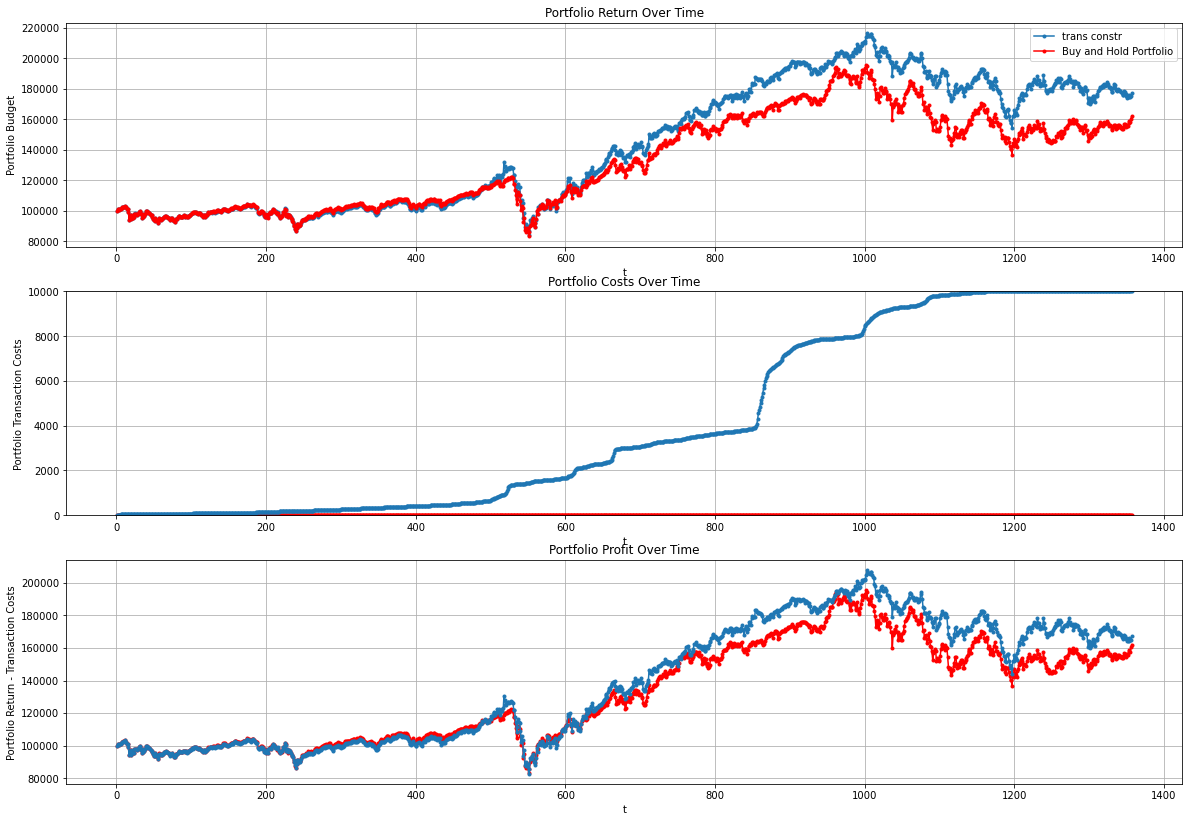

In [30]:
PortfolioSP100Lambda.benchmark([BHSP100])

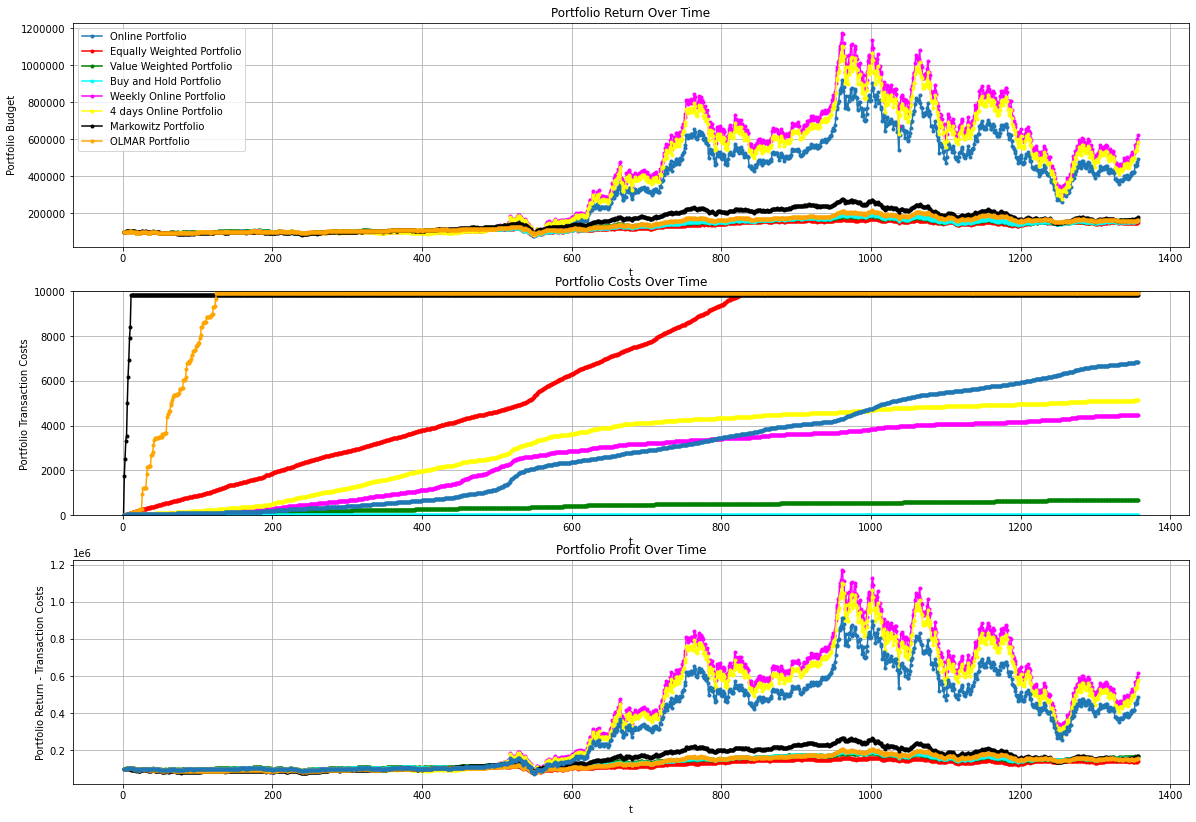

In [28]:
PortfolioSP100.benchmark(benchmark = [EWSP100,VWSP100,BHSP100,PortfolioSP100_w,PortfolioSP100_fd,MWSP100,OLMAR])

In [29]:
PortfolioSP100.run_metrics([EWSP100,VWSP100,BHSP100,PortfolioSP100_w,PortfolioSP100_fd,OLMAR,MWSP100,PortfolioSP100Lambda],exclude_metrics = ["Annualized Return"])

╒════════════════════════════╤══════════════╤════════════════╤════════════════════╤═════════════════╤═════════════════════╤═══════════════╤═════════════╕
│                            │  Profit (%)  │  Sharpe Ratio  │  Max Drawdown (%)  │  Sortino Ratio  │  Information Ratio  │  Ulcer Ratio  │  Winning %  │
╞════════════════════════════╪══════════════╪════════════════╪════════════════════╪═════════════════╪═════════════════════╪═══════════════╪═════════════╡
│ Equally Weighted Portfolio │   51.5735    │   0.0152049    │       31.12        │    0.0230869    │          0          │    1.01352    │  0.547531   │
├────────────────────────────┼──────────────┼────────────────┼────────────────────┼─────────────────┼─────────────────────┼───────────────┼─────────────┤
│ Value Weighted Portfolio   │   69.4971    │   0.0216627    │      28.4174       │    0.0327896    │      0.0220905      │    1.0588     │  0.551216   │
├────────────────────────────┼──────────────┼────────────────┼──────────────

### Lambda graph


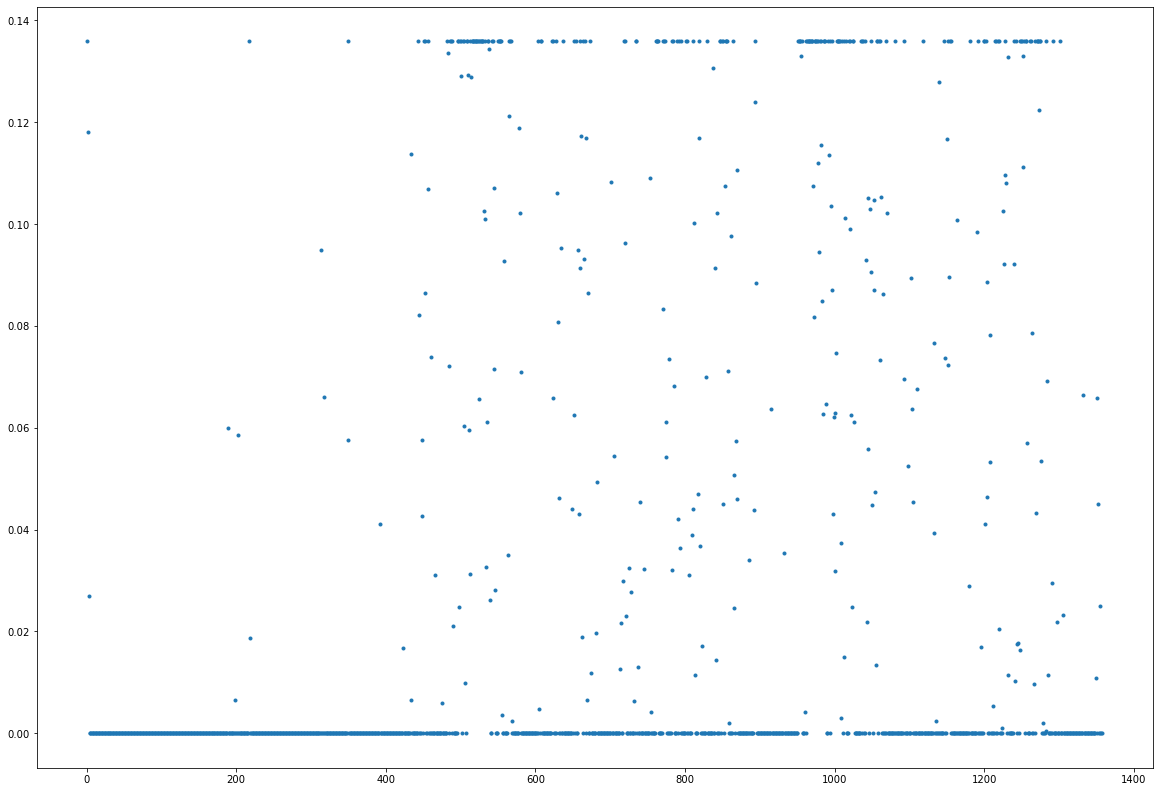

In [95]:
#grafico dual vector  senza upper bound
plt.figure(figsize=(20, 14))
plt.plot([i for i in range(1,len(PortfolioSP100Lambda.stocks)-1)],PortfolioSP100.lambda_list, marker='o',
                     linestyle=' ',markersize = 3,label=PortfolioSP100Lambda.label) 